In [1]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

from functools import partial
from tqdm import tqdm
import pickle
from chainconsumer import ChainConsumer

import jax
import jax.numpy as jnp
jnp.ones([1,2])


import haiku as hk
from haiku._src.nets.resnet import ResNet18
import optax

from sbi_lens.normflow.models import AffineSigmoidCoupling, ConditionalRealNVP
from sbi_lens.gen_dataset.lensing_lognormal_dataset import LensingLogNormalDataset

'unset XLA_FLAGS'


Populating the interactive namespace from numpy and matplotlib


'unset XLA_FLAGS'

In [3]:
import logging


import tensorflow_probability as tfp; tfp = tfp.substrates.jax

# this prints a WARNING

tfp.distributions.TransformedDistribution(
    tfp.distributions.Normal(0.0, 1.0), tfp.bijectors.Identity()
)

logger = logging.getLogger("root")


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

# this does not print a WARNING

tfp.distributions.TransformedDistribution(
    tfp.distributions.Normal(0.0, 1.0), tfp.bijectors.Identity()
)

<tfp.distributions.TransformedDistribution 'identityNormal' batch_shape=[] event_shape=[] dtype=float32>

# Build compressor

In [4]:
# create nf to train using mutual information
bijector_layers_compressor = [128] * 2

bijector_compressor = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers_compressor, 
  n_components=16, 
  activation=jax.nn.silu
)

NF_compressor = partial(
  ConditionalRealNVP, 
  n_layers=4, 
  bijector_fn=bijector_compressor
)

class Flow_nd_Compressor(hk.Module):
    def __call__(self, y):
        nvp = NF_compressor(2)(y)
        return nvp
nf = hk.without_apply_rng(hk.transform(lambda theta, y : Flow_nd_Compressor()(y).log_prob(theta).squeeze()))
# ResNet 18
params_nf = nf.init(jax.random.PRNGKey(8),  0.5*jnp.ones([1,2]), 0.5*jnp.ones([1,2]))
compressor = hk.transform_with_state(lambda x : ResNet18(2)(x, is_training=True))
parameters_resnet, opt_state_resnet  = compressor.init(jax.random.PRNGKey(873457568), 0.5*jnp.ones([1,128,128,5]))

parameters_compressor = hk.data_structures.merge(parameters_resnet, params_nf)



In [5]:
#### Remember to import these few lines after the previus cell to avoid CUDA error

tfd= tfp.distributions
tfb = tfp.bijectors
import tensorflow_datasets as tfds
import tensorflow as tf

# Dataset

In [6]:
# load and create dataset
ds = tfds.load(
    'LensingLogNormalDataset/Gaussian_model_year_1', 
    split='train', 
    data_dir = 'tensorflow_dataset'
)

In [7]:
tf.random.set_seed(1)
                           
def augmentation_with_noise(example):

      N=128
      map_size=5
      gal_per_arcmin2=10
      sigma_e=0.26
      pix_area = (map_size * 60 / N)**2  

      ex = tf.expand_dims(example['simulation'], axis = -1)
      noise = tf.random.normal(
          shape=(N, N, 1), 
          stddev=sigma_e/tf.math.sqrt(gal_per_arcmin2 * pix_area)
      )
      x = ex + noise
      x = tf.image.random_flip_left_right(x)
      x = tf.image.random_flip_up_down(x)

      return {'simulation': x, 'theta': example['theta'], 'score': example['score']}
    
def reshape(example):
      ex = example['simulation']
      x = tf.transpose(ex)
      return {'simulation': x, 'theta': example['theta'], 'score': example['score']}

## Training

In [8]:

def loss_mse(params, mu, batch, state_resnet):
  y, opt_state_resnet = compressor.apply(
      params, state_resnet, None, batch.reshape([-1,128,128,5])
  )
  loss = jnp.mean(jnp.sum((y - mu)**2, axis=1))
  return loss, opt_state_resnet

@jax.jit
def update_compressor_with_mse(params, opt_state, mu, batch, state_resnet):
    """Single SGD update step."""
    (loss, opt_state_resnet), grads = jax.value_and_grad(loss_mse, has_aux = True)(params, mu, batch, state_resnet)
    updates, new_opt_state = optimizer_c.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state, opt_state_resnet

In [9]:
def loss_vmim(params, mu, batch, state_resnet):
  y, opt_state_resnet = compressor.apply(
      params, state_resnet, None, batch.reshape([-1,128,128,5])
  )
  log_prob = jax.vmap(
      lambda theta, x: nf.apply(
          params, 
          theta.reshape([1,2]), 
          x.reshape([1,2])
      ).squeeze()
  )(mu, y)
  return -jnp.mean(log_prob) , opt_state_resnet

@jax.jit
def update_compressor_with_vmim(params, opt_state, mu, batch, state_resnet):
    """Single SGD update step."""
    (loss, opt_state_resnet), grads = jax.value_and_grad(
        loss_vmim, 
        has_aux = True
    )(params, mu, batch, state_resnet)
    updates, new_opt_state = optimizer_c.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state, opt_state_resnet

### Define here how to train the compressor --> MSE or VMIM


In [6]:
Train= 'VMIM'

### Training compressor --> MSE or VMIM

In [11]:
# dataset
ds = tfds.load('LensingLogNormalDataset/Gaussian_model_year_1', 
               split='train[:80000]', 
               data_dir = 'tensorflow_dataset')

ds = ds.repeat()
ds = ds.shuffle(1000)
ds = ds.map(reshape)
ds = ds.map(augmentation_with_noise)
ds = ds.batch(128)
ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
ds_train = iter(tfds.as_numpy(ds))

total_steps = 100_000# usually 200_000
lr_scheduler = optax.piecewise_constant_schedule(
    init_value=0.001,
    boundaries_and_scales={int(total_steps*0.1):0.7,
                           int(total_steps*0.2):0.7,
                           int(total_steps*0.3):0.7,
                           int(total_steps*0.4):0.7,
                           int(total_steps*0.5):0.7,
                           int(total_steps*0.6):0.7,
                           int(total_steps*0.7):0.7,
                           int(total_steps*0.8):0.7,
                           int(total_steps*0.9):0.7}
)
optimizer_c = optax.adam(learning_rate=lr_scheduler)
opt_state_c = optimizer_c.init(parameters_compressor)
batch_loss=[]


In [12]:
if Train=='MSE':
    for batch in tqdm(range(total_steps)):
        sample = next(ds_train)
        l, parameters_compressor, opt_state_c, opt_state_resnet = update_compressor_with_mse(
            parameters_compressor,
            opt_state_c, 
            sample['theta'],
            sample['simulation'], 
            opt_state_resnet
        )

        if batch % 100 == 0:
            batch_loss.append(l)
            
elif Train=='VMIM':
    for batch in tqdm(range(total_steps)):
        sample = next(ds_train)
        l, parameters_compressor, opt_state_c, opt_state_resnet = update_compressor_with_vmim(
            parameters_compressor,
            opt_state_c, 
            sample['theta'],
            sample['simulation'], 
            opt_state_resnet
        )

        if batch % 100 == 0:
            batch_loss.append(l)

100%|██████████| 100000/100000 [4:50:43<00:00,  5.73it/s] 


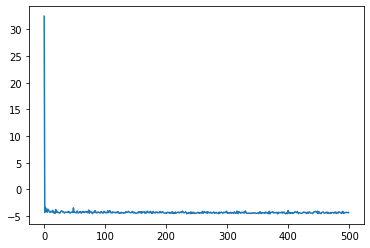

In [13]:
plt.plot(batch_loss[:500])

In [14]:
import pickle
with open("params_nd_compressor_{}.pkl".format(Train), "wb") as fp:
  pickle.dump(parameters_compressor, fp)

with open("opt_state_resnet_{}.pkl".format(Train), "wb") as fp:
  pickle.dump(opt_state_resnet, fp)

# SBI

## Create NF for SBI

In [17]:
# import pickle

# with open("params_nd_compressor_{}.pkl".format(Train), 'rb') as f:
#     params_nd_compressor = pickle.load(f)
# ##################################################
# with open("opt_state_resnet_{}.pkl".format(Train), 'rb') as g:
#     opt_state_resnet = pickle.load(g)

In [15]:
params_nd_compressor=parameters_compressor

In [12]:
bijector_layers = [128] * 2

bijector_npe = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers, 
  n_components=16, 
  activation=jax.nn.silu
)

NF_npe = partial(
    
  ConditionalRealNVP, 
  n_layers=4, 
  bijector_fn=bijector_npe
)

prior = tfd.MultivariateNormalDiag(jnp.array([0.3,0.8]), 0.05*jnp.ones(2))
theta = prior.sample(10000,jax.random.PRNGKey(0))
scale_theta = (jnp.std(theta, axis = 0)/0.06)
shift_theta = jnp.mean(theta/scale_theta, axis = 0)-0.5

class SmoothNPE(hk.Module):
    def __call__(self, y):
        net = y
        nvp = NF_npe(2)(net)
        nf = tfd.TransformedDistribution(
            nvp,
            tfb.Chain([tfb.Scale(scale_theta),tfb.Shift(shift_theta)])
        )
        return nf

nvp_nd = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNPE()(y).log_prob(theta).squeeze()))
params_nd = nvp_nd.init(jax.random.PRNGKey(42), 0.5*jnp.ones([1,2]), 0.5*jnp.ones([1,2]))

## Training

In [17]:
# define loss function and model update
def loss_fn(params, parameters_compressor, opt_state_resnet, weight, mu, batch, score):

  y, _ = compressor.apply(parameters_compressor, opt_state_resnet, None, batch.reshape([-1,128,128,5]))
  
  log_prob, out = jax.vmap(
    jax.value_and_grad(lambda theta, x: nvp_nd.apply(params, theta.reshape([1,2]), x.reshape([1,2])).squeeze())
    )(mu, y)

  nll = - jnp.mean(log_prob)
  sm = jnp.mean(jnp.sum((out - score)**2, axis=1))
      
  return nll + weight * sm

@jax.jit
def update(params, parameters_compressor, opt_state, opt_state_resnet, weight, mu, batch, score):
    """Single SGD update step."""
    loss, grads  = jax.value_and_grad(loss_fn)(
        params,
        parameters_compressor, 
        opt_state_resnet, 
        weight, 
        mu,
        batch, 
        score
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [ ]:
score_weight = 0

ds = tfds.load('LensingLogNormalDataset/Gaussian_model_year_1', 
               split='train[80000:]', 
               data_dir = 'tensorflow_dataset')

ds = ds.repeat()
ds = ds.shuffle(1000)
ds = ds.map(reshape)
ds = ds.map(augmentation_with_noise)
ds = ds.batch(128)
ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
ds_train = iter(tfds.as_numpy(ds))

#optimizer
total_steps = 100_000
lr_scheduler = optax.piecewise_constant_schedule(
    init_value=0.001,
    boundaries_and_scales={int(total_steps*0.2):0.7,
                           int(total_steps*0.4):0.7,
                           int(total_steps*0.6):0.7,
                           int(total_steps*0.8):0.7}
)

optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state = optimizer.init(params_nd)

batch_loss=[]
for batch in tqdm(range(total_steps)):
    samples = next(ds_train)
    l, params_nd, opt_state = update(
        params_nd, 
        params_nd_compressor, 
        opt_state, 
        opt_state_resnet,
        score_weight, 
        samples['theta'], 
        samples['simulation'], 
        samples['score']
    )

    if batch % 100 == 0:
        batch_loss.append(l)

 63%|██████▎   | 63293/100000 [3:06:03<1:49:32,  5.58it/s]

In [ ]:
plt.plot(batch_loss)

In [ ]:

with open("params_nd_{}.pkl".format(Train), "wb") as fp:
  pickle.dump(params_nd, fp)

with open("opt_state_{}.pkl".format(Train), "wb") as fp:
  pickle.dump(opt_state, fp)



## Create fiducial and plot results

In [15]:
m_data = tf.transpose(np.load("data/map_gaussian_tomo_with_noise.npy")).numpy()

In [13]:
import pickle

with open("data/params_nd_compressor_{}.pkl".format(Train), 'rb') as f:
    params_nd_compressor = pickle.load(f)
##################################################
with open("data/opt_state_resnet_{}.pkl".format(Train), 'rb') as g:
    opt_state_resnet = pickle.load(g)

In [14]:
import pickle

with open("data/params_nd_{}.pkl".format(Train), 'rb') as f:
    params_nd = pickle.load(f)
##################################################
with open("data/opt_state_{}.pkl".format(Train), 'rb') as g:
    opt_state = pickle.load(g)

In [16]:
y, _ = compressor.apply(
    params_nd_compressor, opt_state_resnet, None, m_data.reshape([1,128,128,5])
)
nvp_sample_nd = hk.transform(
    lambda x : SmoothNPE()(x).sample(566933, seed=hk.next_rng_key())
)

sample_nd = nvp_sample_nd.apply(
    params_nd, 
    rng = jax.random.PRNGKey(43), 
    x = y*jnp.ones([566933,2])
)

In [18]:
samples_ff=np.load("data/posterior_full_field__128N_5ms_10gpa_0.26se.npy",allow_pickle=True)

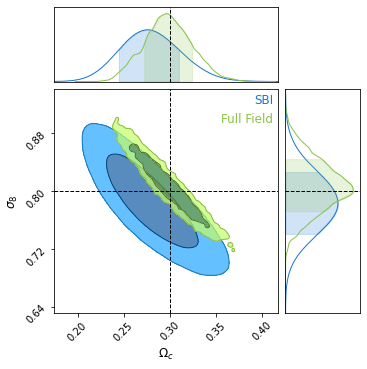

In [19]:
c = ChainConsumer()
c.add_chain(sample_nd, parameters=["$\Omega_c$", "$\sigma_8$"], name='SBI')
c.add_chain(samples_ff, parameters=["$\Omega_c$", "$\sigma_8$"], name='Full Field')
fig = c.plotter.plot(figsize="column", truth = [0.3,0.8])


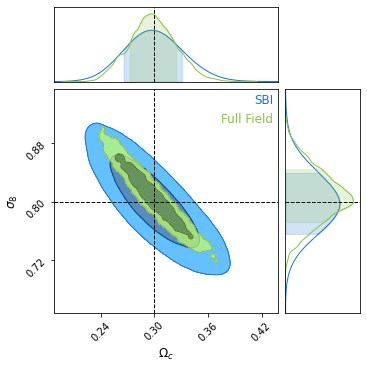

In [18]:
c = ChainConsumer()
c.add_chain(sample_nd, parameters=["$\Omega_c$", "$\sigma_8$"], name='SBI')
c.add_chain(samples_ff, parameters=["$\Omega_c$", "$\sigma_8$"], name='Full Field')
fig = c.plotter.plot(figsize="column", truth = [0.3,0.8])


2023-02-09 20:26:29.767387: E external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:1272] --xla_hlo_profile for GPU is unsupported.
2023-02-09 20:26:29.962724: E external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:1272] --xla_hlo_profile for GPU is unsupported.
2023-02-09 20:26:30.049047: E external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:1272] --xla_hlo_profile for GPU is unsupported.
2023-02-09 20:26:30.224876: E external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:1272] --xla_hlo_profile for GPU is unsupported.
2023-02-09 20:26:30.391450: E external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:1272] --xla_hlo_profile for GPU is unsupported.
2023-02-09 20:26:30.477323: E external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:1272] --xla_hlo_profile for GPU is unsupported.
2023-02-09 20:26:30.561484: E external/org_tensorflow/tensorflow/compiler/xl

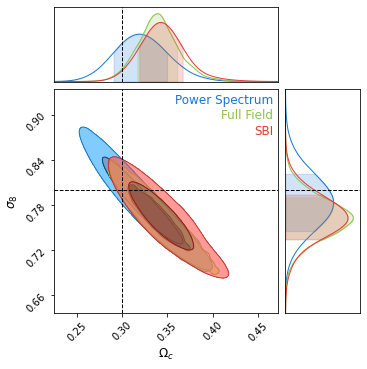

In [27]:
# y, _ = compressor.apply(
#     parameters_compressor, opt_state_resnet, None, m_data.reshape([1,128,128,1])
# )
# nvp_sample_nd = hk.transform(
#     lambda x : SmoothNPE()(x).sample(len(samples_ps), seed=hk.next_rng_key())
# )
# sample_nd = nvp_sample_nd.apply(
#     params_nd, 
#     rng = jax.random.PRNGKey(43), 
#     x = y*jnp.ones([len(samples_ps),2])
# )


# c = ChainConsumer()
# c.add_chain(samples_ps, parameters=["$\Omega_c$", "$\sigma_8$"], name='Power Spectrum')
# c.add_chain(samples_ff, parameters=["$\Omega_c$", "$\sigma_8$"], name='Full Field')
# c.add_chain(sample_nd, parameters=["$\Omega_c$", "$\sigma_8$"], name='SBI')
# fig = c.plotter.plot(figsize="column", truth = [0.3,0.8])